In [1]:
import tensorflow


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import IPython.display as display

In [3]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [5]:
feature = _float_feature(np.exp(1))

In [6]:
feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [7]:
# the number of observations in the dataset
n_observations = int(1e4)

# boolean feature, encoded as False or True


feature0 = np.random.choice([False, True], n_observations)


feature1 = np.random.randint(0, 5, n_observations)

# string feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [8]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }
  
  # Create a Features message using tf.train.Example.
  
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [9]:
example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04'

In [10]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

In [11]:
tf.data.Dataset.from_tensor_slices(feature1)

<DatasetV1Adapter shapes: (), types: tf.int64>

In [12]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<DatasetV1Adapter shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [13]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'goat', shape=(), dtype=string)
tf.Tensor(-0.8106255579853229, shape=(), dtype=float64)


In [14]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_func(
    serialize_example, 
    (f0,f1,f2,f3),  # pass these args to the above function.
    tf.string)      # the return type is <a href="../../api_docs/python/tf#string"><code>tf.string</code></a>.
  return tf.reshape(tf_string, ()) # The result is a scalar

In [15]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


<DatasetV1Adapter shapes: (), types: tf.string>

In [16]:
filename = 'test.tfrecord'

In [18]:
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [19]:
filenames=[filename]

In [20]:
raw_dataset = tf.data.TFRecordDataset(filenames)

In [21]:
raw_dataset


<TFRecordDatasetV1 shapes: (), types: tf.string>

In [23]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: id=53, shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04(\x85O\xbf'>
<tf.Tensor: id=55, shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xdd\x05X?'>
<tf.Tensor: id=57, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04yx\xa0\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: id=59, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04.r\x8f?'>
<tf.Tensor: id=61, shape=(

In [24]:
# Create a description of the features.  
feature_description = {
    'feature0': tf.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.FixedLenFeature([], tf.float32, default_value=0.0),
}


In [25]:
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.parse_single_example(example_proto, feature_description)

In [26]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset 

<DatasetV1Adapter shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [27]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: id=101, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=102, shape=(), dtype=int64, numpy=4>, 'feature2': <tf.Tensor: id=103, shape=(), dtype=string, numpy=b'goat'>, 'feature3': <tf.Tensor: id=104, shape=(), dtype=float32, numpy=-0.81062555>}
{'feature0': <tf.Tensor: id=109, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=110, shape=(), dtype=int64, numpy=3>, 'feature2': <tf.Tensor: id=111, shape=(), dtype=string, numpy=b'horse'>, 'feature3': <tf.Tensor: id=112, shape=(), dtype=float32, numpy=0.84383947>}
{'feature0': <tf.Tensor: id=117, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=118, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=119, shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: id=120, shape=(), dtype=float32, numpy=-1.2536765>}
{'feature0': <tf.Tensor: id=125, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=126, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=127,

In [28]:
record_iterator = tf.python_io.tf_record_iterator(path=filename)

for string_record in record_iterator:
  example = tf.train.Example()
  example.ParseFromString(string_record)
  
  print(example)
  
  # Exit after 1 iteration as this is purely demonstrative.
  break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.8106255531311035
      }
    }
  }
}



In [29]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

16384/15477 [===============================] - 0s 1us/step


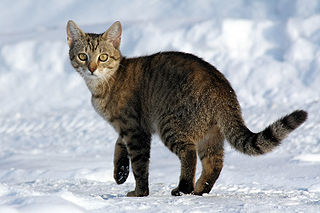

In [30]:
display.display(display.Image(filename=cat_in_snow))

In [31]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [34]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape
    
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'imag_raw': _bytes_feature(image_string),
    }
    
    return tf.train.Example(features= tf.train.Features(feature = feature))
for line in str(image_example(image_string, label)).split('\n')[:15]:
    print(line)
print("...")
    

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


In [35]:
with tf.pyhon_io.TFRecordWriter("images.tfrecords") as writer:
    for filename,label in image_labels.items():
        image_string = open(filename, 'rb').read()
        tf_example = image_example(image_string, label)
        writer.write(tf_example.SerializeToString())

AttributeError: module 'tensorflow' has no attribute 'pyhon_io'